In [1]:
'''
Author: LiuSheng
Date: 2025-02-26 14:17:40
LastEditTime: 2025-02-26 14:49:29
Description: 
'''
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, shift
import SimpleITK as sitk
from scipy.optimize import minimize


In [2]:
fingerprint_filepath = r"D:\workspace\SPECT_project\fingerprint.json"

with open(fingerprint_filepath, "r") as f:
    fingerprint = json.load(f)
    
    
imgpath = r"Y:\labspace\DataCollection\Project\RadiSmart\cardiac\healthy_nii\000149118\108_SA.nii.gz"
imgpath = r"Y:\labspace\DataCollection\Project\RadiSmart\cardiac\healthy_nii\000149118\108_From_SA_scaled.nii.gz"
sitk_img = sitk.ReadImage(imgpath)
scaled_sa_img = sitk.GetArrayFromImage(sitk_img)[0]
scaled_sa_img = np.transpose(scaled_sa_img, (1, 0, 2))

imgpath = r"Y:\labspace\DataCollection\Project\RadiSmart\cardiac\healthy_nii\000149118\seg.nii.gz"
sitk_img = sitk.ReadImage(imgpath)
mask_img = sitk.GetArrayFromImage(sitk_img)
mask_img = np.transpose(mask_img, (1, 0, 2))


print(scaled_sa_img.shape, mask_img.shape)


(57, 60, 60) (57, 60, 60)


In [3]:
# fig = plt.figure(figsize=(10, 10))
# for i in range(scaled_sa_img.shape[0]):
#     ax = fig.add_subplot(8, 8, i+1)
#     ax.imshow(scaled_sa_img[i], cmap="gray")
#     ax.contour(mask_img[i], cmap="gray")
#     ax.axis("off")

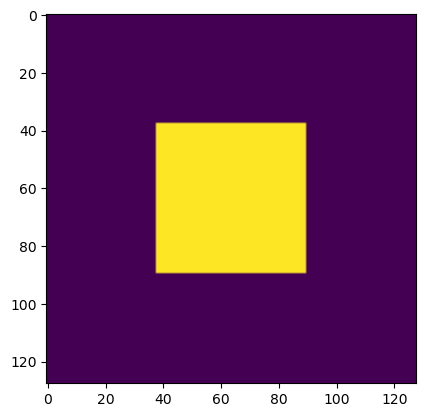

In [4]:
import numpy as np

def process_image(image2d, cy, cx):
    """
    处理输入的 2D 图像：
    - 如果大于 128x128，从中心裁切成 128x128。
    - 如果小于 128x128，以图像为中心，用 0 填充成 128x128。

    参数:
    image2d (numpy.ndarray): 输入的 2D 图像，形状为 (height, width)。

    返回:
    numpy.ndarray: 处理后的 128x128 图像。
    """
    # 获取输入图像的高度和宽度
    height, width = image2d.shape

    # 目标尺寸
    target_size = 128

    # 如果图像大于目标尺寸，裁切中心区域
    if height > target_size or width > target_size:
        # 计算裁切区域的起始和结束索引
        start_y = (height - target_size) // 2
        start_x = (width - target_size) // 2
        end_y = start_y + target_size
        end_x = start_x + target_size

        # 裁切中心区域
        processed_image = image2d[start_y:end_y, start_x:end_x]

    # 如果图像小于目标尺寸，填充 0
    else:
        # 计算填充的上下左右宽度
        pad_height = (target_size - height) // 2
        pad_width = (target_size - width) // 2

        # 计算剩余的填充（如果目标尺寸与输入尺寸的差是奇数）
        pad_height_remainder = (target_size - height) % 2
        pad_width_remainder = (target_size - width) % 2

        # 使用 np.pad 进行填充
        processed_image = np.pad(
            image2d,
            ((pad_height, pad_height + pad_height_remainder),
             (pad_width, pad_width + pad_width_remainder)),
            mode='constant', constant_values=0
        )

    return processed_image


test_img = np.ones((52, 52))
process_image_arr = process_image(test_img, 0, 0)
plt.imshow(process_image_arr)

(57, 60, 60) (57, 60, 60)
(64, 60, 60)


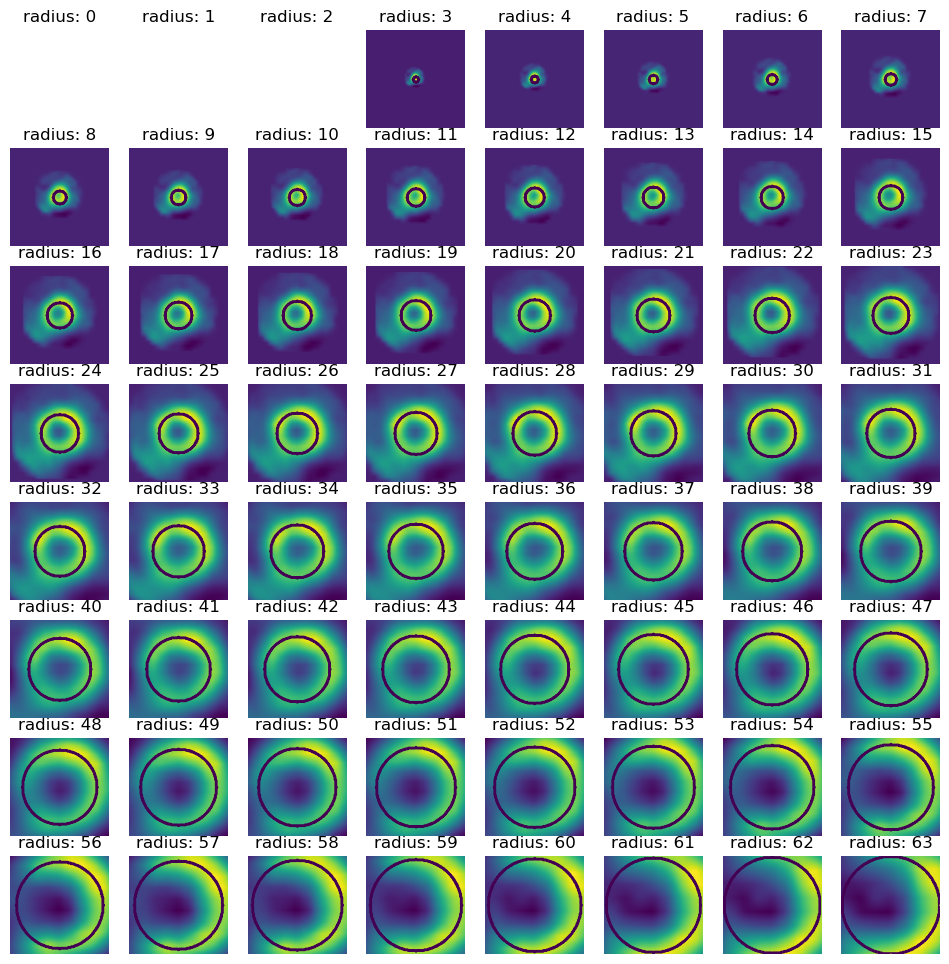

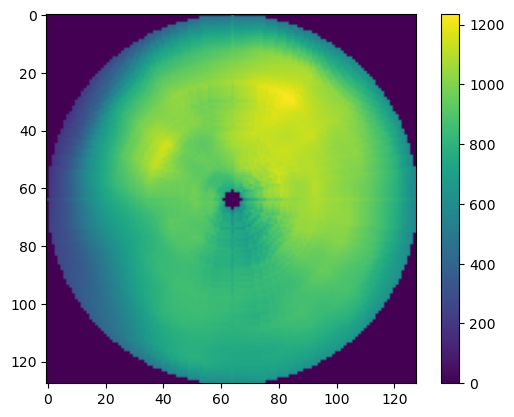

In [24]:
### version 1
def create_eye_of_bull_image(img3d, mask3d, output_size=(128, 128)):
    print(img3d.shape, mask3d.shape)
    # 获取 3D 图像的尺寸
    z_dim, y_dim, x_dim = img3d.shape
    cy, cx = 33,28.5
    
    # 初始化空的牛眼图
    bullseye_image = np.zeros(output_size)
    
    zs, _, _ = np.where(mask3d)
    z_min, z_max = zs.min(), zs.max()
    tmp_z_add = 0
    z_max+=tmp_z_add
    z_range = z_max - z_min + 1
    sacale_factor = min(output_size) / 2 / z_range
    
    scaled_img3d = zoom(img3d[z_min: z_max+1], (sacale_factor, 1, 1), order=3)
    scaled_mask3d = zoom(mask3d[z_min: z_max+1], (sacale_factor, 1, 1), order=0)
    
    
    print(scaled_img3d.shape)
    
    plt.figure(figsize=(12, 12))
    # 对于每一层z轴，创建牛眼图的圆环
    for z in range(scaled_img3d.shape[0]):
        
        # 提取当前z层的心脏横截面，假设取中心区域
        img2d = scaled_img3d[z, :, :]
        mask2d = scaled_mask3d[z, :, :]
        
        Y, X = np.ogrid[:y_dim, :x_dim]
        # if z<scaled_img3d.shape[0]-tmp_z_add:
        #     cost_func = lambda params: np.sum(img2d*mask2d * (np.sqrt((Y - cy)**2 + (X - cx)**2) - params[0])**2)
        # else:
        #     print(z, 2222)
        #     cost_func = lambda params: np.sum(img2d * (np.sqrt((Y - cy)**2 + (X - cx)**2) - params[0])**2)
        cost_func = lambda params: np.sum(img2d*mask2d * (np.sqrt((Y - cy)**2 + (X - cx)**2) - params[0])**2)
        result = minimize(cost_func, x0 = [mask2d.shape[0] / 4], bounds=[(1, mask2d.shape[0]//2)])
        
        # cost_func = lambda params: np.sum(img2d * (np.sqrt((Y - cy)**2 + (X - cx)**2) - params[0])**2)
            
        
        mask_r = result.x[0]
        
        # if z>scaled_img3d.shape[0]-tmp_z_add:
        #     mask_r = 9
        cy_r, cx_r = cy, cx
        
        ax = plt.subplot(8, 8, z+1)
        
        # plt.imshow(img2d,  vmax=np.max(scaled_img3d))
        # # plt.contour(mask2d)
        # # 绘制圆形
        # plt.scatter(cx_r, cy_r, c='r', s=5)
        # circle = plt.Circle((cx_r, cy_r), mask_r, fill=False)
        # ax.add_artist(circle)
        
        plt.title(f"radius: {z}")
        ax.set_axis_off()
        
        if z<3:
            continue
        
        s_factor = z/mask_r
        # 将当前横截面图像缩放到牛眼图的大小
        # 可以用插值方式调整大小，这里简单的使用zoom进行缩放
        
        
        img2d = shift(img2d, (y_dim/2-cy_r, x_dim/2-cx_r), order=1)
        resized_img2d = zoom(img2d, s_factor, order=1)
        
        p_img2d = process_image(resized_img2d, 33,28.5)
        
        
        # 计算当前z层应在牛眼图中的圆环位置
        radius = z
        
        # 创建当前圆环区域的掩码
        Y,X = np.ogrid[:output_size[0], :output_size[1]]
        
        mask1 = (X - 64) ** 2 + (Y - 64) ** 2 <= (radius+1) ** 2
        mask2 = (X - 64) ** 2 + (Y - 64) ** 2 > (radius) ** 2
        
        mask = mask1 & mask2
        
        plt.imshow(p_img2d)
        plt.contour(mask)
        
        # # 将该层的心脏横截面映射到牛眼图中
        bullseye_image[mask] = p_img2d[mask]
        
    return bullseye_image



bulleye = create_eye_of_bull_image(scaled_sa_img, mask_img)
plt.show()

plt.imshow(bulleye)
plt.colorbar()
plt.show()

(57, 60, 60) (57, 60, 60)
(64, 60, 60)


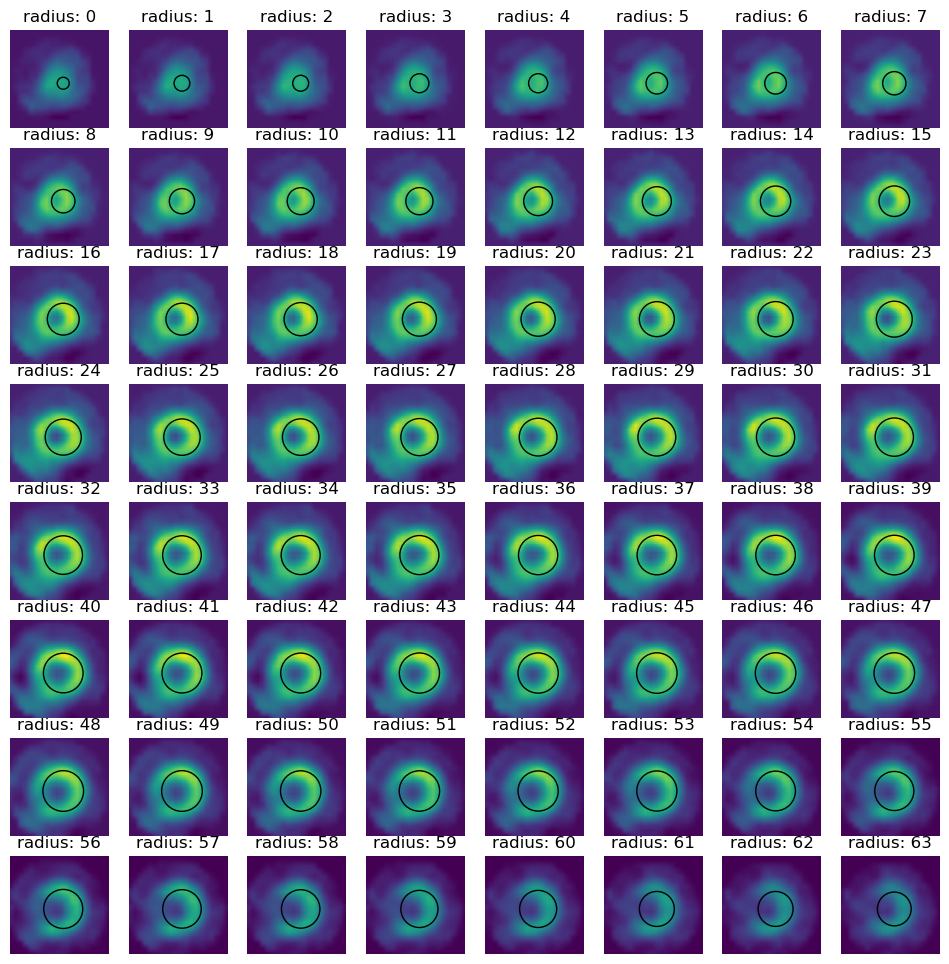

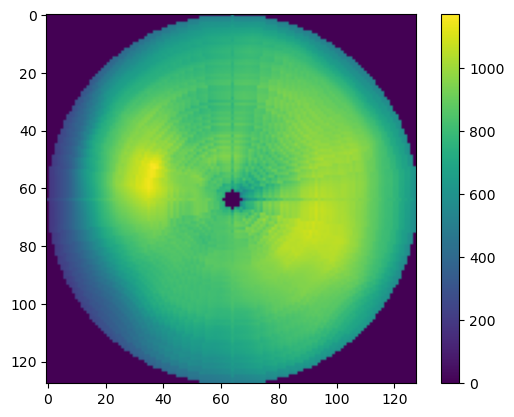

In [ ]:
# ### version 1
# def create_eye_of_bull_image(img3d, mask3d, output_size=(128, 128)):
#     print(img3d.shape, mask3d.shape)
#     # 获取 3D 图像的尺寸
#     z_dim, y_dim, x_dim = img3d.shape
#     # cy, cx = (y_dim/2, x_dim/2)
#     cy, cx = 33,28.5
    
#     # 初始化空的牛眼图
#     bullseye_image = np.zeros(output_size)
    
#     zs, _, _ = np.where(mask3d)
#     z_min, z_max = zs.min(), zs.max()
#     z_range = z_max - z_min + 1
#     sacale_factor = min(output_size) / 2 / z_range
    
#     scaled_img3d = zoom(img3d[z_min: z_max+1], (sacale_factor, 1, 1), order=3)
#     scaled_mask3d = zoom(mask3d[z_min: z_max+1], (sacale_factor, 1, 1), order=0)
    
#     # scaled_img3d = shift(scaled_img3d, (0, y_dim/2-cy, x_dim/2-cx))
#     # scaled_mask3d = shift(scaled_mask3d, (0, y_dim/2-cy, x_dim/2-cx))
    
#     print(scaled_img3d.shape)
    
#     plt.figure(figsize=(12, 12))
#     # 对于每一层z轴，创建牛眼图的圆环
#     for z in range(scaled_img3d.shape[0]):
        
#         # 提取当前z层的心脏横截面，假设取中心区域
#         img2d = scaled_img3d[z, :, :]
#         mask2d = scaled_mask3d[z, :, :]
        
#         Y, X = np.ogrid[:y_dim, :x_dim]
#         # cost_func = lambda params: np.sum(img2d*mask2d * (np.sqrt((Y - params[1])**2 + (X - params[2])**2) - params[0])**2)
#         # result = minimize(cost_func, x0 = [mask2d.shape[0] / 4, 0, 0], bounds=[(1, mask2d.shape[0]//2), (30, 34), (30, 34)])
#         cost_func = lambda params: np.sum(img2d*mask2d * (np.sqrt((Y - cy)**2 + (X - cx)**2) - params[0])**2)
#         # cost_func = lambda params: np.sum(img2d*mask2d * (np.sqrt((Y - 34)**2 + (X - 30)**2) - params[0])**2)
#         result = minimize(cost_func, x0 = [mask2d.shape[0] / 4], bounds=[(1, mask2d.shape[0]//2)])
        
#         # mask_r, cy_r, cx_r = result.x
#         mask_r = result.x[0]
#         cy_r, cx_r = cy, cx
        
#         ax = plt.subplot(8, 8, z+1)
#         plt.imshow(img2d,  vmax=np.max(scaled_img3d))
#         # plt.imshow(img2d)
#         # img2d = shift(img2d, (32 - cy, 32 - cx))
#         # plt.imshow(img2d, vmax=np.max(scaled_img3d))
        
#         # plt.contour(mask2d)
#         # 绘制圆形
#         circle = plt.Circle((32, 32), mask_r, fill=False)
#         ax.add_artist(circle)
#         plt.title(f"radius: {z}")
#         ax.set_axis_off()
        
#         if z<3:
#             continue
        
#         s_factor = z/mask_r
#         # 将当前横截面图像缩放到牛眼图的大小
#         # 可以用插值方式调整大小，这里简单的使用zoom进行缩放
        
#         resized_img2d = zoom(img2d, s_factor, order=1)
        
#         # print(11111, resized_img2d.shape)
#         p_img2d = process_image(resized_img2d, 33,28.5)
#         # print(22222, p_img2d.shape)
        
#         # p_img2d = shift(p_img2d, (-4, -5))
        
#         # 计算当前z层应在牛眼图中的圆环位置
#         radius = z
        
#         # 创建当前圆环区域的掩码
#         Y,X = np.ogrid[:output_size[0], :output_size[1]]
        
#         mask1 = (X - 64) ** 2 + (Y - 64) ** 2 <= (radius+1) ** 2
#         mask2 = (X - 64) ** 2 + (Y - 64) ** 2 > (radius) ** 2
        
#         mask = mask1 & mask2
        
#         # plt.imshow(p_img2d)
#         # plt.contour(mask)
        
#         # 将该层的心脏横截面映射到牛眼图中
#         bullseye_image[mask] = p_img2d[mask]
        
#     return bullseye_image



# bulleye = create_eye_of_bull_image(scaled_sa_img, mask_img)
# plt.show()

# plt.imshow(bulleye)
# plt.colorbar()
# plt.show()

(57, 60, 60) (57, 60, 60)
(64, 60, 60)


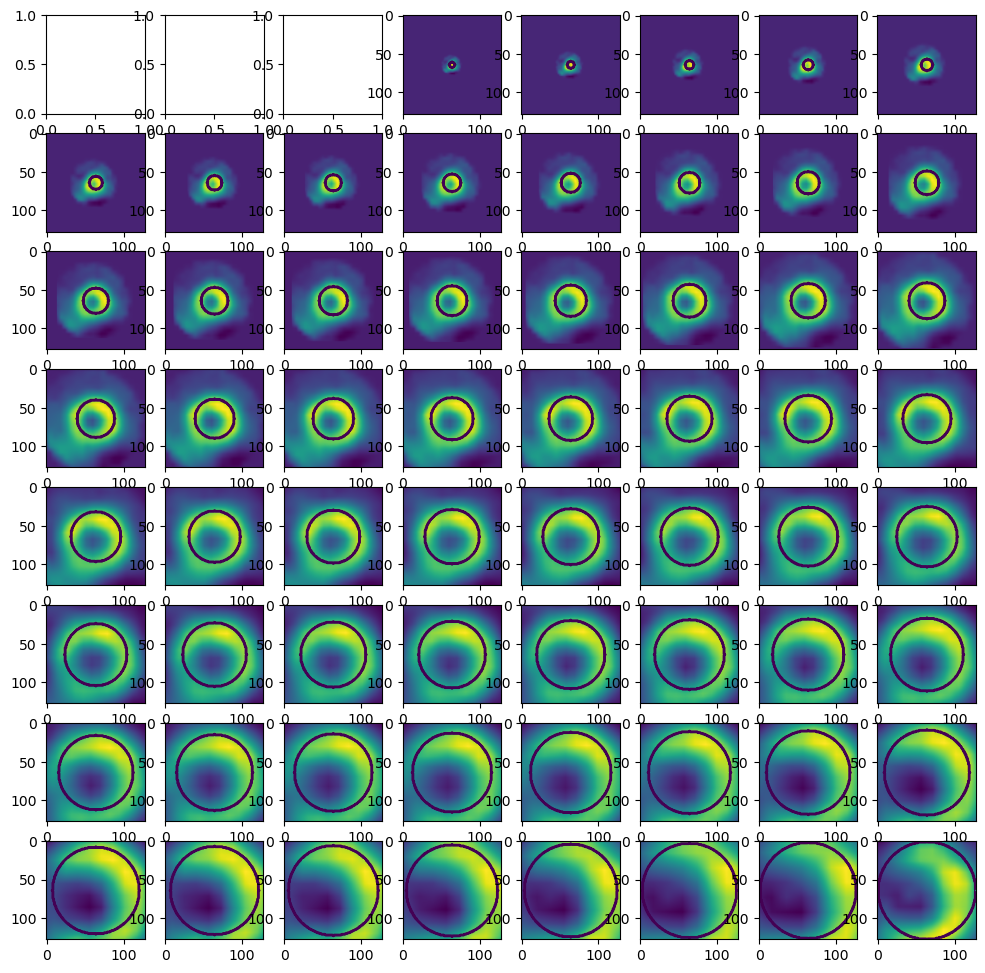

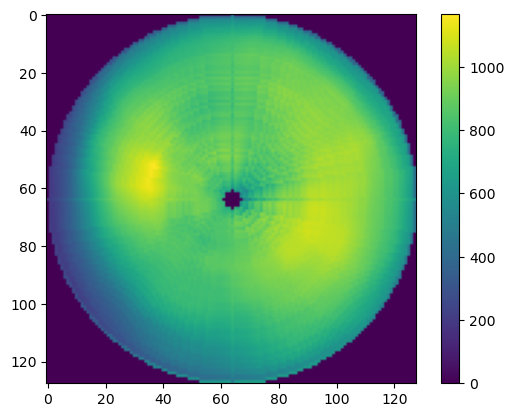

In [14]:
### version 2
def create_eye_of_bull_image(img3d, mask3d, output_size=(128, 128)):
    print(img3d.shape, mask3d.shape)
    # 获取 3D 图像的尺寸
    z_dim, y_dim, x_dim = img3d.shape
    cy, cx = (y_dim/2, x_dim/2)
    
    # 初始化空的牛眼图
    bullseye_image = np.zeros(output_size)
    
    zs, _, _ = np.where(mask3d)
    z_min, z_max = zs.min(), zs.max()
    z_range = z_max - z_min + 1
    sacale_factor = min(output_size) / 2 / z_range
    
    scaled_img3d = zoom(img3d[z_min: z_max+1], (sacale_factor, 1, 1), order=1)
    scaled_mask3d = zoom(mask3d[z_min: z_max+1], (sacale_factor, 1, 1), order=0)
    
    print(scaled_img3d.shape)
    
    plt.figure(figsize=(12, 12))
    # 对于每一层z轴，创建牛眼图的圆环
    for z in range(scaled_img3d.shape[0]):
        
        # 提取当前z层的心脏横截面，假设取中心区域
        img2d = scaled_img3d[z, :, :]
        mask2d = scaled_mask3d[z, :, :]
        
        Y, X = np.ogrid[:y_dim, :x_dim]
        cost_func = lambda params: np.sum(img2d*mask2d * (np.sqrt((Y - params[1])**2 + (X - params[2])**2) - params[0])**2)
        result = minimize(cost_func, x0 = [mask2d.shape[0] / 4, 0, 0], bounds=[(1, mask2d.shape[0]//2), (30, 34), (30, 34)])
        # cost_func = lambda params: np.sum(img2d*mask2d * (np.sqrt((Y - cy)**2 + (X - cx)**2) - params[0])**2)
        # result = minimize(cost_func, x0 = [mask2d.shape[0] / 4], bounds=[(1, mask2d.shape[0]//2)])
        
        mask_r, cy_r, cx_r = result.x
        # mask_r = result.x[0]
        # cy_r, cx_r = cy, cx
        
        ax = plt.subplot(8, 8, z+1)
        # plt.imshow(img2d)
        # plt.contour(mask2d)
        # # 绘制圆形
        # circle = plt.Circle((cx_r, cy_r), mask_r, fill=False)
        # ax.add_artist(circle)
        # plt.title(f"radius: {z}")
        # ax.set_axis_off()
        
        if z<3:
            continue
        
        s_factor = z/mask_r
        # 将当前横截面图像缩放到牛眼图的大小
        # 可以用插值方式调整大小，这里简单的使用zoom进行缩放
        
        resized_img2d = zoom(img2d, s_factor, order=1)
        
        # print(11111, resized_img2d.shape)
        p_img2d = process_image(resized_img2d)
        # print(22222, p_img2d.shape)
        
        # 计算当前z层应在牛眼图中的圆环位置
        radius = z
        
        # 创建当前圆环区域的掩码
        Y,X = np.ogrid[:output_size[0], :output_size[1]]
        
        mask1 = (X - 64) ** 2 + (Y - 64) ** 2 <= (radius+1) ** 2
        mask2 = (X - 64) ** 2 + (Y - 64) ** 2 > (radius) ** 2
        mask = mask1 & mask2
        
        
        mask_r1 = (X - 64) ** 2 + (Y - 64) ** 2 <= (radius+1) ** 2
        mask_r2 = (X - 64) ** 2 + (Y - 64) ** 2 > (radius) ** 2
        mask = mask1 & mask2
        
        plt.imshow(p_img2d)
        plt.contour(mask)
        
        # shift_mask = shift(mask, (cy_r-cy, cx_r-cx))
        # shift_y, shift_x = int(np.round(cy_r-cy)), int(np.round(cx_r-cx))
        
        # shifted_mask = shift(mask, shift=(shift_y, shift_x), mode='constant', cval=0)
        
        shifted_mask = mask
        # 将该层的心脏横截面映射到牛眼图中
        bullseye_image[mask] = p_img2d[shifted_mask]
        
    return bullseye_image



bulleye = create_eye_of_bull_image(scaled_sa_img, mask_img)
plt.show()

plt.imshow(bulleye)
plt.colorbar()
plt.show()

In [ ]:
# version 2

def create_eye_of_bull_image(img3d, mask3d, output_size=(128, 128)):
    # 获取 3D 图像的尺寸
    z_dim, y_dim, x_dim = img3d.shape
    cy, cx = (y_dim/2, x_dim/2)
    
    # 初始化空的牛眼图
    bullseye_image = np.zeros(output_size)
    
    zs, _, _ = np.where(mask3d)
    z_min, z_max = zs.min(), zs.max()
    z_range = z_max - z_min + 1
    sacale_factor = min(output_size) / 2 / z_range
    
    scaled_img3d = zoom(img3d[z_min: z_max+1], (sacale_factor, 1, 1), order=1)
    scaled_mask3d = zoom(mask3d[z_min: z_max+1], (sacale_factor, 1, 1), order=0)
    
    print(scaled_img3d.shape)
    
    plt.figure(figsize=(12, 12))
    # 对于每一层z轴，创建牛眼图的圆环
    for z in range(scaled_img3d.shape[0]):
        
        # 提取当前z层的心脏横截面，假设取中心区域
        img2d = scaled_img3d[z, :, :]
        mask2d = scaled_mask3d[z, :, :]
        
        Y, X = np.ogrid[:y_dim, :x_dim]
        cost_func = lambda params: np.sum(img2d*mask2d * (np.sqrt((Y - params[1])**2 + (X - params[2])**2) - params[0])**2)
        result = minimize(cost_func, x0 = [mask2d.shape[0] / 4, 0, 0], bounds=[(1, mask2d.shape[0]//2), (30, 34), (30, 34)])
        
        mask_r, cy_r, cx_r = result.x
        
        
        # masked_img = img2d * mask2d
        # ys, xs = np.where(masked_img==np.max(masked_img))
        # cy_r, cx_r = cy, cx
        # mask_r = np.sqrt(ys[0] - cy)**2 + (xs[0] - cx)**2
        # print(mask_r)
        
        # mask_r = result.x[0]
        # cy_r, cx_r = result.x[1], result.x[2]
        
        # s_factor = z / mask_r
        # print(z, mask_r, s_factor)
        
        
        ax = plt.subplot(8, 8, z+1)
        plt.imshow(img2d)
        plt.contour(mask2d)
        # 绘制圆形
        circle = plt.Circle((cx_r, cy_r), mask_r, fill=False)
        ax.add_artist(circle)
        plt.title(f"radius: {z}")
        ax.set_axis_off()
        
        # if z<3:
        #     continue
        # # 将当前横截面图像缩放到牛眼图的大小
        # # 可以用插值方式调整大小，这里简单的使用zoom进行缩放
        # resized_img2d = zoom(img2d, s_factor, order=1)
        
        # p_img2d = process_image(resized_img2d)
        
        # # 计算当前z层应在牛眼图中的圆环位置
        # radius = z
        
        # # 创建当前圆环区域的掩码
        # Y,X = np.ogrid[:output_size[0], :output_size[1]]
        # mask1 = (X - cx // 2) ** 2 + (Y - cy // 2) ** 2 <= (radius+1) ** 2
        # mask2 = (X - cx // 2) ** 2 + (Y - cy // 2) ** 2 > (radius) ** 2
        
        # mask = mask1 & mask2
        # # print(mask.shape, p_img2d.shape)
        
        #     # 使用 numpy.roll 进行平移
            
        # shift_y, shift_x = np.round((cy_r-cy, cx_r-cx)).astype(int)
        
        # shifted_mask = np.roll(mask, shift=shift_y, axis=0)  # 垂直平移
        # shifted_mask = np.roll(shifted_mask, shift=shift_x, axis=1)  # 水平平移

        # # 处理边界（将超出部分填充为 0）
        # if shift_y > 0:
        #     shifted_mask[:shift_y, :] = 0  # 向下平移，顶部填充 0
        # elif shift_y < 0:
        #     shifted_mask[shift_y:, :] = 0  # 向上平移，底部填充 0

        # if shift_x > 0:
        #     shifted_mask[:, :shift_x] = 0  # 向右平移，左侧填充 0
        # elif shift_x < 0:
        #     shifted_mask[:, shift_x:] = 0  # 向左平移，右侧填充 0
        # # mask_r = shift(mask, np.round((cy_r-cy, cx_r-cx)))
        # # plt.imshow(mask_r)
        # # plt.show()
        # # print(mask.shape, mask_r.shape)
        
        # # mask1_r = (X - cx // 2) ** 2 + (Y - cy // 2) ** 2 <= (radius+1) ** 2
        # # mask2_r = (X - cx // 2) ** 2 + (Y - cy // 2) ** 2 > (radius) ** 2
        
        # # 将该层的心脏横截面映射到牛眼图中
        # bullseye_image[mask] = p_img2d[shifted_mask]
        
    return bullseye_image



bulleye = create_eye_of_bull_image(scaled_sa_img, mask_img)

plt.imshow(bulleye)
plt.colorbar()
plt.show()

0 1225 565.1112060546875 (128, 128)


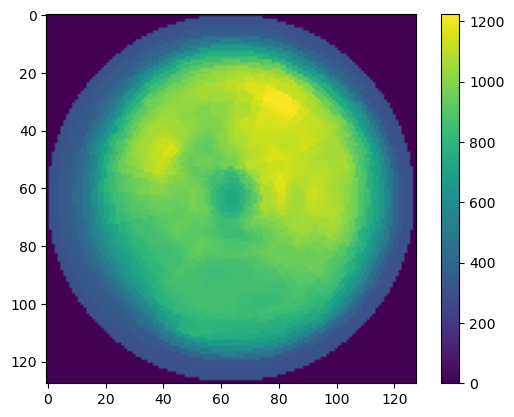

In [65]:
fingerprint_filepath = r"D:\workspace\SPECT_project\fingerprint.json"

with open(fingerprint_filepath, "r") as f:
    fingerprint = json.load(f)

# 000149118 -> Patient_0000
# 000652515 -> Patient_0002
# 002475009 -> Patient_0014
# 600360681 -> Patient_0077
# 600860468 -> Patient_0102

case_info = fingerprint["Patient_0000"]

sitk_img = sitk.ReadImage(case_info["Polar_img"][0].replace("/mnt/labnas/", "Y:\\labspace\\"))
polar_img = sitk.GetArrayFromImage(sitk_img)[0]

plt.imshow(polar_img)
print(polar_img.min(), polar_img.max(), polar_img.mean(), polar_img.shape)
plt.colorbar()

(19, 64, 64)


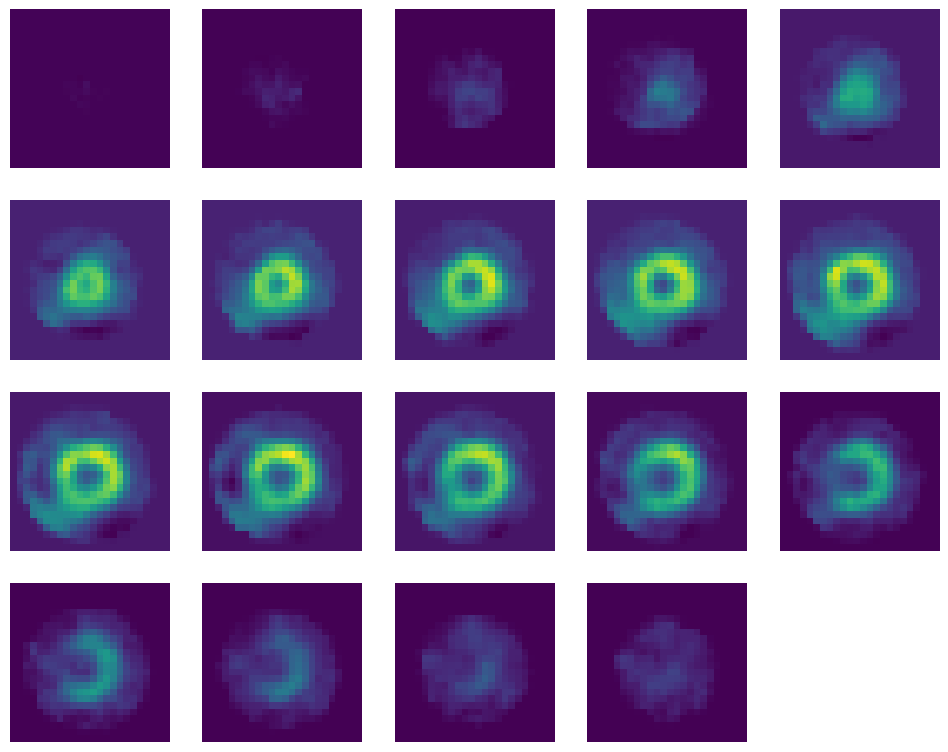

In [77]:
case_info = fingerprint["Patient_0000"]

sitk_img = sitk.ReadImage(case_info["SA_img"][0].replace("/mnt/labnas/", "Y:\\labspace\\"))
sa_img = sitk.GetArrayFromImage(sitk_img)
print(sa_img.shape)

fig = plt.figure(figsize=(12, 12))
for i in range(sa_img.shape[0]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(sa_img[i][20:44, 20:44], vmax = np.max(sa_img))
    # ax.colorbar()
    # plt.colorbar()
    ax.axis("off")
    
# plt.imshow(polar_img)
# print(polar_img.min(), polar_img.max(), polar_img.mean(), polar_img.shape)
# plt.colorbar()